### Document Clustering
EXISTING script.

Since downloading a wikipedia dump, I've started my code over from scratch. `reformat.py` contains some important code to preprocess the outputted wiki dump from the wikiextractor I used.

This notebook will open a few sample JSON files and attempt to cluster them and label the clusters. This isn't hierarchical right now (only 1 level of clustering).

The

In [20]:
import json
import glob

In [21]:
CLUSTER_SIZE = 50

In [22]:
wiki_articles = []
for x in glob.glob('data/wiki*.json'):
    new_articles = json.load(open(x))['articles']
    wiki_articles += new_articles
wiki_articles[0].keys()

dict_keys(['url', 'text', 'id', 'title'])

In [23]:
for article in wiki_articles[:5]:
    for key, val in article.items():
        if key != 'text':
            print(key, ':', val)

url : https://en.wikipedia.org/wiki?curid=894
id : 894
title : Agnosticism
url : https://en.wikipedia.org/wiki?curid=896
id : 896
title : Argon
url : https://en.wikipedia.org/wiki?curid=897
id : 897
title : Arsenic
url : https://en.wikipedia.org/wiki?curid=898
id : 898
title : Antimony
url : https://en.wikipedia.org/wiki?curid=899
id : 899
title : Actinium


Looks like my JSON conversions worked! The only problem now, is finding links that are actually related to one another so I can effectively test my clustering algorithm. I don't have my data pre-organized by topics...

We'll wee what we can visualize with T-SNE first.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.8, max_features=20000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))
wiki_articles_text = [x['text'] for x in wiki_articles]
wiki_articles_titles = [x['title'] for x in wiki_articles]
tfidf_vectors = tfidf.fit_transform(wiki_articles_text)

In [25]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_vectors)


In [26]:
from sklearn.cluster import KMeans
num_clusters = 10

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_vectors)

clusters = km.labels_.tolist()

CPU times: user 3.91 s, sys: 4 ms, total: 3.92 s
Wall time: 3.92 s


In [27]:
from sklearn.externals import joblib
joblib.dump(km,  'doc_cluster{}.pkl'.format(num_clusters))

km = joblib.load('doc_cluster{}.pkl'.format(num_clusters))
clusters = km.labels_.tolist()

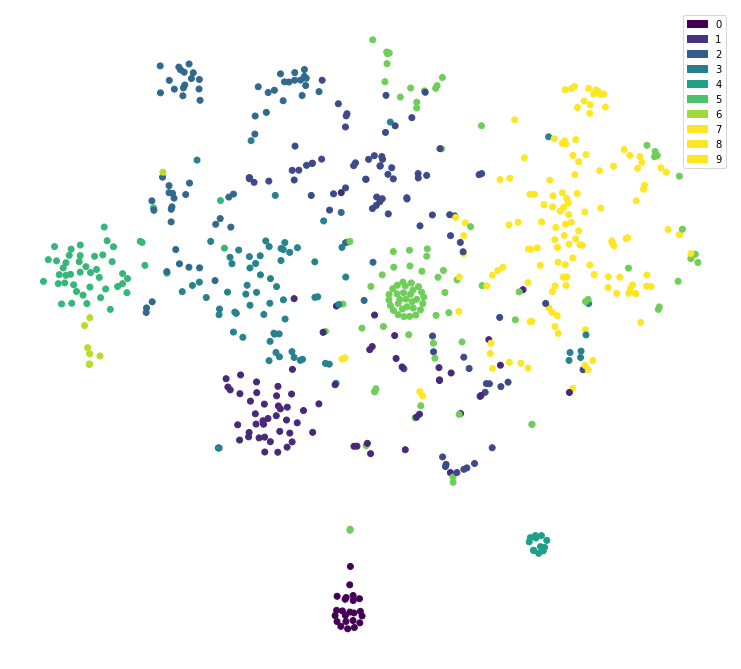

In [40]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(tfidf_vectors)
X_embedded = TSNE(n_components=2, perplexity=40, verbose=0).fit_transform(X_reduced)
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=clusters, marker="o")
#plt.colorbar()
cmap = plt.cm.get_cmap('viridis', 8) 
plt.legend([mpatches.Patch(color=cmap(b)) for b in range(num_clusters)],
           [str(x) for x in range(num_clusters)])
plt.show()

The above is the t-SNE visualization after clustering. may want to improve clarity and try something like [this](https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)

In [41]:
cluster_titles = dict()
for cluster, title in zip(clusters, wiki_articles_titles):
    if cluster not in cluster_titles:
        cluster_titles[cluster] = []
    cluster_titles[cluster].append(title)

In [43]:
for cluster, titles in cluster_titles.items():
    print(cluster, ':' , ', '.join(titles), '\n')

0 : August, August 22, August 27, August 6, August 23, August 24, August 31, August 9, August 13, August 2, August 7, August 8, August 14, August 15, August 16, August 17, August 12, August 18, August 19, August 21, August 25, August 1, August 3 

1 : Andrey Markov, A. A. Milne, Alvin Toffler, The Amazing Spider-Man, Albert Speer, Ada Lovelace, August Derleth, Albert Camus, Agatha Christie, The Plague, Hercule Poirot, Miss Marple, Allen Ginsberg, Anatoly Karpov, An American in Paris, Academy Awards, Actrius, Animalia (book), International Atomic Time, Ayn Rand, Alain Connes, Allan Dwan, List of Atlas Shrugged characters, Andre Agassi, Animal Farm, Aleksandr Solzhenitsyn, August Wilhelm Ambros, Albert Schweitzer, Austrian School, Alexis Carrel, Anatole France, André Gide, The Ashes, America's National Game, Augustin-Jean Fresnel, Alan Garner, Afro Celt Sound System, Alfred Hitchcock, A Clockwork Orange (novel), Alfred Nobel, Alexander Graham Bell, Andy Warhol, Akira Kurosawa, A. E. van 

K-means doesn't guarantee cluster sizes, but we won't worry too much about that for now. 

for `doc_cluster.pkl`: Clusters 9 and 11 clearly worked well, since August and April dates are all grouped. 10 looks pretty good, with a bunch of mathematics terminology (plus some stuff about atoms). 8 looks to be about famous people, 7 is a bit of a mess. Let's call it miscellaneous stuff. 6 is another group of historical people. 5 is... plants/flowers/animals! 4 is another of miscellaneous stuff.. 3 looks like geographical things, 2 is mostly people, 1 is religious things, and 0 looks like greek gods and whatnot. 

for `doc_cluster20.pkl`: 20 clusters definitely improved things a bit. The number of clusters used will be something to experiment with. Maybe I can define some kind of metric later on to show how "good" each num_cluster param is. Once again we have groups of greek mythology, people, august, april, math, and more. 


This is really neat. But the challenge now is to actually generate labels for each cluster myself. [this](https://nlp.stanford.edu/IR-book/html/htmledition/cluster-labeling-1.html) looks like a good reference.